## Demuxalot + detection of new SNPs

an example of demultiplexing using a single bamfile

(demuxalot can deal with multiple bamfiles simulteneously - it is far more efficient than merging bamfiles,
but not shown in this tutorial)

We only need some amount of information about each genotype.
New SNPs found without any reference (like 1000 Genomes or so) and tailored specifically for your case.

In [1]:
import os
from pathlib import Path
import pandas as pd
import pysam

from demuxalot.utils import download_file
from demuxalot import BarcodeHandler, ProbabilisticGenotypes, Demultiplexer, count_snps, detect_snps_positions

In [2]:
local_path = Path.home().joinpath('demuxalot_examples/new_snps_simplified')
local_path.mkdir(exist_ok=True)
os.chdir(local_path)

In [3]:
bamfile_location = download_file("https://sra-pub-src-1.s3.amazonaws.com/SRR5398237/C.merged.bam.1", "C.merged.bam.1")

vcf_filename = download_file(
    "https://github.com/yelabucsf/demuxlet_paper_code/raw/master/fig2/b1.b2.b3.merged_32.eagle.hrc.imputed.autosomes.dose.mac1.exon.recode.vcf.gz",
    "32_donors.vcf",
)

barcode_filename = download_file('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2560247&format=file&file=GSM2560247%5Fbarcodes%2Etsv%2Egz', 'barcodes/C.tsv.gz')

file C.merged.bam.1 already exists locally
file 32_donors.vcf already exists locally
file barcodes/C.tsv.gz already exists locally


In [4]:
handler = BarcodeHandler.from_file(barcode_filename)

# well, that's the names that were used in the original data.
# Recommendation: use better names when you do the same,
# like Donor6, Donor11, ...
genotype_names = [
    '6', '11', '12', '13', '15', '16', '18', '21',
    '1015', '1016', '1026', '1043', '1039', '1112', '1012',
    '1249', '1244', '1066', '1488', '1511', '1311', '1286',
    '1256', '1493', '1442', '1453', '1598', '1085', '1079',
    '1154', '107', '101'
]
genotype_names.sort()
genotypes = ProbabilisticGenotypes(genotype_names=genotype_names)
# prior_strength reflect confidence in assigned genotypes.
# should be relative to scrnaseq read. Confidence of assignment ~100 reads from rnaseq
genotypes.add_vcf(vcf_filename, prior_strength=100)

In [5]:
if not Path(bamfile_location).with_suffix('.bam.bai').exists():
    pysam.index(bamfile_location)

In [6]:
counts = count_snps(
    bamfile_location=bamfile_location,
    chromosome2positions=genotypes.get_chromosome2positions(),
    barcode_handler=handler,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed:   28.0s remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed:   37.6s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed:   50.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:   56.9s remaining:   56.9s
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:  1.4min remaining:   47.2s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:  1.5min remaining:   27.2s
[Parallel(n_jobs=-1)]: Done  20 out of  22 | elapsed:  2.1min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  3.0min finished


,n_molecules,n_snp_calls
chromosome,,
1,127877,170086
10,32523,49629
11,96458,139208
12,84067,120897
13,13089,17346
14,48582,77598
15,120040,227546
16,128174,159860
17,78852,119157


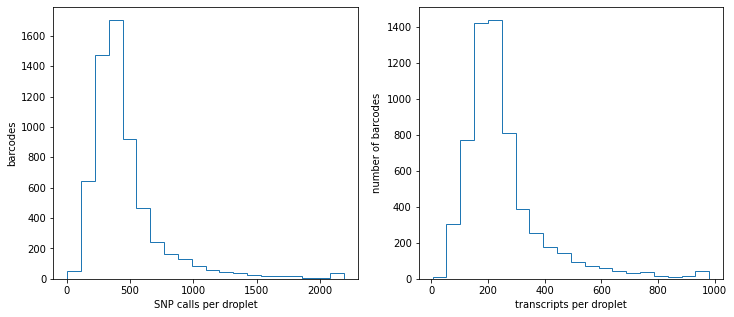

In [7]:
from demuxalot import utils
utils.summarize_counted_SNPs(counts)

## Enrichment with new SNPs

In [8]:
new_snps_filename = 'new_snps_single_file.betas'
_ = detect_snps_positions(
    bamfile_location=str(bamfile_location),
    genotypes=genotypes,
    barcode_handler=handler,
    minimum_coverage=200,
    minimum_alternative_coverage=10,
    result_beta_prior_filename=new_snps_filename,
    n_best_snps_per_donor=100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed:   16.6s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed:   40.5s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed:   49.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:  1.4min remaining:   47.1s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:  1.5min remaining:   25.7s
[Parallel(n_jobs=-1)]: Done  20 out of  22 | elapsed:  1.9min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  2.9min finished


During inference of SNPs for 101 will use 1 barcodes
During inference of SNPs for 1012 will use 0 barcodes
During inference of SNPs for 1015 will use 0 barcodes
During inference of SNPs for 1016 will use 0 barcodes
During inference of SNPs for 1026 will use 0 barcodes
During inference of SNPs for 1039 will use 0 barcodes
During inference of SNPs for 1043 will use 807 barcodes
During inference of SNPs for 1066 will use 0 barcodes
During inference of SNPs for 107 will use 0 barcodes
During inference of SNPs for 1079 will use 775 barcodes
During inference of SNPs for 1085 will use 808 barcodes
During inference of SNPs for 11 will use 0 barcodes
During inference of SNPs for 1112 will use 0 barcodes
During inference of SNPs for 1154 will use 805 barcodes
During inference of SNPs for 12 will use 0 barcodes
During inference of SNPs for 1244 will use 0 barcodes
During inference of SNPs for 1249 will use 699 barcodes
During inference of SNPs for 1256 will use 0 barcodes
During inference of SNPs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of 382 | elapsed:   22.4s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  68 out of 382 | elapsed:   37.1s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done 103 out of 382 | elapsed:  1.1min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done 138 out of 382 | elapsed:  1.6min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done 173 out of 382 | elapsed:  2.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done 208 out of 382 | elapsed:  2.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done 243 out of 382 | elapsed:  2.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 278 out of 382 | elapsed:  2.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 313 out of 382 | elapsed:  2.9min remaining:   38.1s
[Parallel(n_jobs=-1)]: Done 348 out of 382 | elapsed:  2.9min remaining:   16.9s
[Parallel(n_jobs=-1)]: Done 382 out of 382 | elapsed:  5.4min finished


In [9]:
genotypes_with_new_snps = genotypes.clone()
# adding new positions to genotypes
# since there is indeed only positions, no any genotype-specific information
genotypes_with_new_snps.add_prior_betas(new_snps_filename, prior_strength=1)

Provided prior information about genotypes: []
No information for genotypes: ['101', '1012', '1015', '1016', '1026', '1039', '1043', '1066', '107', '1079', '1085', '11', '1112', '1154', '12', '1244', '1249', '1256', '1286', '13', '1311', '1442', '1453', '1488', '1493', '15', '1511', '1598', '16', '18', '21', '6']


In [10]:
# counting with new SNPs
counts_enriched = count_snps(
    bamfile_location=str(bamfile_location),
    chromosome2positions=genotypes_with_new_snps.get_chromosome2positions(),
    barcode_handler=handler,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  27 | elapsed:    0.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of  27 | elapsed:    4.7s remaining:   27.2s
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed:   40.2s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:   42.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed:   49.3s remaining:   53.1s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.1min remaining:   47.4s
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed:  1.3min remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:  1.7min remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  2.2min remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.2min finished


In [11]:
learnt_enriched_genotypes, probs_learning_new_snps = Demultiplexer.learn_genotypes(
    counts_enriched,
    genotypes_with_new_snps,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [12]:
probs_learning_new_snps.head()

,101,1012,1015,1016,1026,1039,1043,1066,107,1079,...,1598+16,1598+18,1598+21,1598+6,16+18,16+21,16+6,18+21,18+6,21+6
AAACATACCTAGAC-1,3.888159e-98,3.717868e-82,2.461841e-101,3.748476e-93,4.003609e-96,1.501398e-76,2.097479e-60,1.722902e-77,6.319907e-77,3.893139e-85,...,3.936501e-18,7.398986e-21,1.937530e-18,4.280612e-21,2.479855e-63,2.547035e-58,8.510514e-65,2.968032e-61,2.253209e-75,1.445274e-60
AAACATACGGTAGG-1,2.281819e-26,2.916894e-25,1.426697e-37,4.525946e-23,9.181295e-28,1.050273e-30,9.997763e-01,9.162934e-30,3.030367e-29,4.232103e-28,...,1.845811e-19,2.810496e-18,3.419569e-19,2.971743e-20,3.760649e-21,7.135547e-23,1.094877e-22,2.209969e-21,2.432102e-21,2.465598e-23
AAACATTGCGGAGA-1,4.270523e-67,1.352125e-43,2.734072e-50,7.813821e-40,6.296495e-50,1.605907e-34,1.588736e-32,1.757896e-30,3.467128e-30,3.765737e-44,...,2.630225e-27,8.148189e-31,9.821121e-26,2.468318e-32,1.028360e-29,6.988894e-29,6.237978e-32,6.715384e-29,4.053924e-37,6.442061e-29
AAACATTGTGGTCA-1,2.767751e-31,1.173975e-26,1.392868e-28,1.020676e-21,1.228116e-32,4.986659e-34,6.319620e-27,8.714783e-26,3.128611e-31,9.283351e-19,...,2.249940e-20,1.456649e-16,1.557785e-19,2.051788e-19,4.896253e-23,8.806553e-28,7.757248e-23,1.984553e-23,7.500296e-19,9.523677e-27
AAACCGTGAAAAGC-1,2.455680e-79,1.640004e-79,3.935972e-76,5.996760e-59,1.984201e-74,7.151717e-86,1.113616e-60,9.404742e-68,1.152749e-75,1.293347e-69,...,3.161618e-18,2.689764e-15,1.271334e-17,3.025063e-16,3.941435e-55,1.707055e-58,5.443785e-53,1.112374e-54,4.783338e-48,4.694526e-53


In [13]:
# if you need only assignments:
probs_learning_new_snps[probs_learning_new_snps.max(axis=1).gt(0.9)]

# note that threshold should be adjusted according to 1) your confidence in data 2) how pure your sample should be for analysis.
# Threshold of 0.9 is for a vast majority of use-cases

,101,1012,1015,1016,1026,1039,1043,1066,107,1079,...,1598+16,1598+18,1598+21,1598+6,16+18,16+21,16+6,18+21,18+6,21+6
AAACATACCTAGAC-1,3.888159e-98,3.717868e-82,2.461841e-101,3.748476e-93,4.003609e-96,1.501398e-76,2.097479e-60,1.722902e-77,6.319907e-77,3.893139e-85,...,3.936501e-18,7.398986e-21,1.937530e-18,4.280612e-21,2.479855e-63,2.547035e-58,8.510514e-65,2.968032e-61,2.253209e-75,1.445274e-60
AAACATACGGTAGG-1,2.281819e-26,2.916894e-25,1.426697e-37,4.525946e-23,9.181295e-28,1.050273e-30,9.997763e-01,9.162934e-30,3.030367e-29,4.232103e-28,...,1.845811e-19,2.810496e-18,3.419569e-19,2.971743e-20,3.760649e-21,7.135547e-23,1.094877e-22,2.209969e-21,2.432102e-21,2.465598e-23
AAACATTGCGGAGA-1,4.270523e-67,1.352125e-43,2.734072e-50,7.813821e-40,6.296495e-50,1.605907e-34,1.588736e-32,1.757896e-30,3.467128e-30,3.765737e-44,...,2.630225e-27,8.148189e-31,9.821121e-26,2.468318e-32,1.028360e-29,6.988894e-29,6.237978e-32,6.715384e-29,4.053924e-37,6.442061e-29
AAACATTGTGGTCA-1,2.767751e-31,1.173975e-26,1.392868e-28,1.020676e-21,1.228116e-32,4.986659e-34,6.319620e-27,8.714783e-26,3.128611e-31,9.283351e-19,...,2.249940e-20,1.456649e-16,1.557785e-19,2.051788e-19,4.896253e-23,8.806553e-28,7.757248e-23,1.984553e-23,7.500296e-19,9.523677e-27
AAACCGTGAAAAGC-1,2.455680e-79,1.640004e-79,3.935972e-76,5.996760e-59,1.984201e-74,7.151717e-86,1.113616e-60,9.404742e-68,1.152749e-75,1.293347e-69,...,3.161618e-18,2.689764e-15,1.271334e-17,3.025063e-16,3.941435e-55,1.707055e-58,5.443785e-53,1.112374e-54,4.783338e-48,4.694526e-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGACTGTGCCCT-1,1.710241e-34,6.395893e-48,1.018957e-56,7.608605e-43,1.371616e-42,1.396826e-44,3.620965e-40,3.521343e-48,3.360324e-56,1.336041e-39,...,1.956853e-43,4.832765e-32,1.044311e-33,2.537423e-28,1.354922e-45,4.419808e-43,2.646318e-40,2.619026e-38,4.192279e-44,5.632716e-35
TTTGCATGAGCATC-1,1.157684e-79,1.060042e-65,9.649746e-62,5.672383e-49,8.506900e-67,8.341873e-51,9.258276e-35,8.254422e-64,7.253063e-50,2.753462e-53,...,5.859432e-28,9.637313e-26,1.117642e-27,1.519836e-31,1.209223e-29,2.307187e-34,1.006104e-39,1.249442e-31,2.221520e-30,1.009493e-35
TTTGCATGCATTGG-1,1.640273e-59,2.416249e-57,1.750927e-78,1.185723e-56,2.439743e-69,4.534138e-78,3.227681e-56,4.853931e-66,6.416474e-85,2.411987e-62,...,2.023767e-47,1.334936e-39,4.930783e-46,1.529411e-40,1.600904e-48,2.690684e-58,4.095727e-52,1.925362e-44,4.620266e-43,4.064930e-51
TTTGCATGTATCGG-1,7.675805e-79,7.493966e-68,2.655017e-65,1.636796e-50,6.392050e-70,1.215964e-79,9.298261e-45,2.517721e-64,5.768726e-65,2.315997e-42,...,1.730917e-44,4.934915e-46,1.503782e-44,5.303663e-40,3.042135e-52,4.434370e-48,2.527195e-41,6.187892e-50,1.720053e-45,1.715101e-44


## For comparison: if we skipped SNP detection, pipeline would look like this:

In [14]:
_posterior_logits, probs_without_learning = Demultiplexer.predict_posteriors(
    counts,
    genotypes,
    barcode_handler=handler,
    only_singlets=False,
    doublet_prior=0.25,
)

In [15]:
genotypes_improved, probs_with_learning = Demultiplexer.learn_genotypes(
    counts,
    genotypes=genotypes,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [16]:
pd.DataFrame({
    'no learning': probs_without_learning[genotype_names].sum(),
    'learning': probs_with_learning[genotype_names].sum(),
    'with new SNPs': probs_learning_new_snps[genotype_names].sum(),
})

,no learning,learning,with new SNPs
101,0.531971,0.146082,0.055303
1012,0.077515,0.078478,0.042652
1015,0.066738,0.067703,0.028326
1016,0.076142,0.078088,0.036936
1026,0.113209,0.114236,0.042328
1039,0.026208,0.024245,0.005730
1043,761.368455,768.281636,769.157366
1066,0.191489,0.199310,0.149368
107,0.047139,0.047311,0.011065
1079,701.507679,737.014612,737.925315
